<a href="https://colab.research.google.com/github/dominicfanucchi/aai-530_group3/blob/main/LSTM_Vehicle_Count_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 3 Final Project Technical Notebook

Name(s): Dominic Fanucchi, Daniel Grant, Isaack Karanja   
Date:    February 26, 2024

In [ ]:
!pip install datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
dataset = load_dataset(
    "mugithi/down_sampled_file_traffic_dataset",
    data_files={
        "train": "data/train-00000-of-00001.parquet",
        "test": "data/test-00000-of-00001.parquet"
    }
)

In [4]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

In [5]:
# sort by TIMESTAMP
train_df.sort_values(by='TIMESTAMP', inplace=True)
test_df.sort_values(by='TIMESTAMP', inplace=True)
train_df['Day'] = train_df['Day'].astype('category')
test_df['Day'] = test_df['Day'].astype('category')

In [6]:
# normalize numerical features except day
numerical_features = ['avgSpeed', 'vehicleCount', 'Year', 'Month', 'Date_no', 'Hour']
scaler = MinMaxScaler()
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

In [7]:
# one hot encode day
encoder = OneHotEncoder(sparse_output=False)
day_encoded_train = encoder.fit_transform(train_df[['Day']])
day_encoded_test = encoder.transform(test_df[['Day']])

In [8]:
# combine numerical and one-hot encoded categorical features
train_features = np.concatenate([train_df[numerical_features].drop('vehicleCount', axis=1).values, day_encoded_train], axis=1)
test_features = np.concatenate([test_df[numerical_features].drop('vehicleCount', axis=1).values, day_encoded_test], axis=1)

In [9]:
sequence_length = 5  # changeable
def create_sequences(input_data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        X.append(input_data[i:(i + sequence_length)])
        y.append(target_column[i + sequence_length])
    return np.array(X), np.array(y)

In [10]:
# create sequences from the numerical + one-hot encoded features and the target
train_sequences = create_sequences(train_features, train_df['vehicleCount'].values, sequence_length)
test_sequences = create_sequences(test_features, test_df['vehicleCount'].values, sequence_length)

In [11]:
X_train, y_train = train_sequences
X_test, y_test = test_sequences
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [12]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
12500/12500 [==============================] - 71s 5ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 2/10
12500/12500 [==============================] - 67s 5ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 3/10
12500/12500 [==============================] - 66s 5ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 4/10
12500/12500 [==============================] - 67s 5ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 5/10
12500/12500 [==============================] - 66s 5ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 6/10
12500/12500 [==============================] - 67s 5ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 7/10
12500/12500 [==============================] - 68s 5ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 8/10
12500/12500 [==============================] - 67s 5ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 9/10
12500/12500 [==============================] - 66s 5ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 10/10
12500/12500 [==============================

In [ ]:
model.save('/content/drive/MyDrive/IoT_Project/DBDLSTM_model2.keras')

In [13]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/IoT_Project/DBDLSTM_model2.keras')

In [ ]:
# predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

6250/6250 [==============================] - 18s 3ms/step


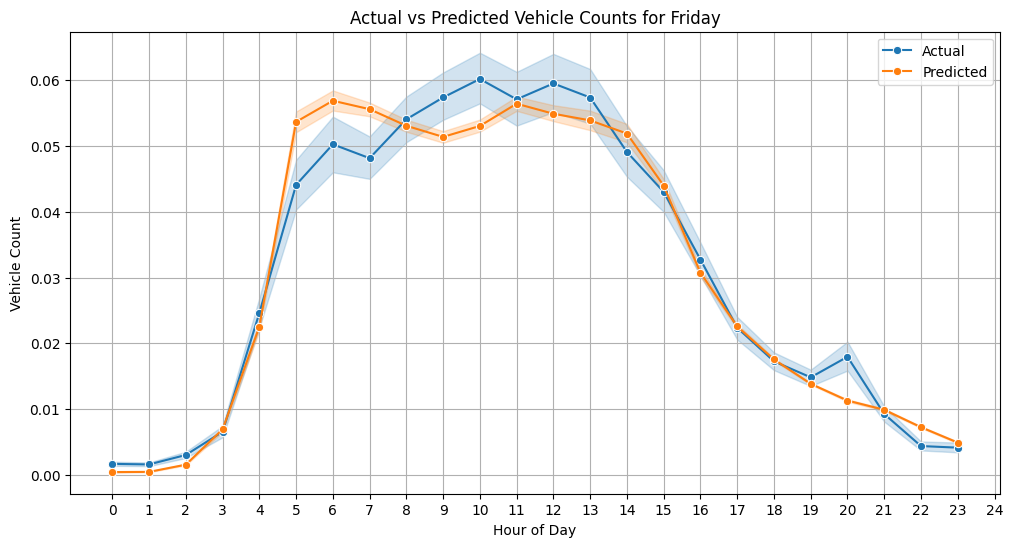

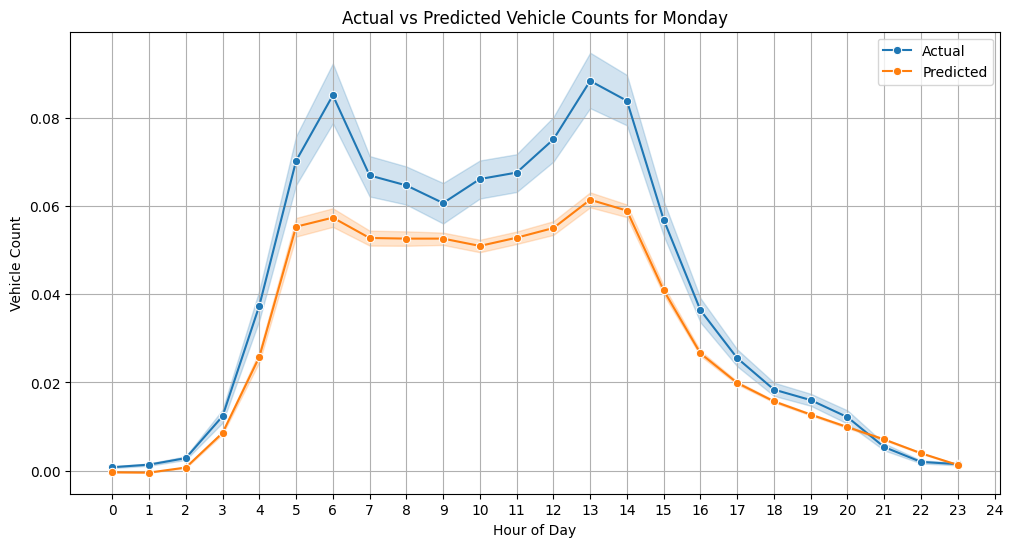

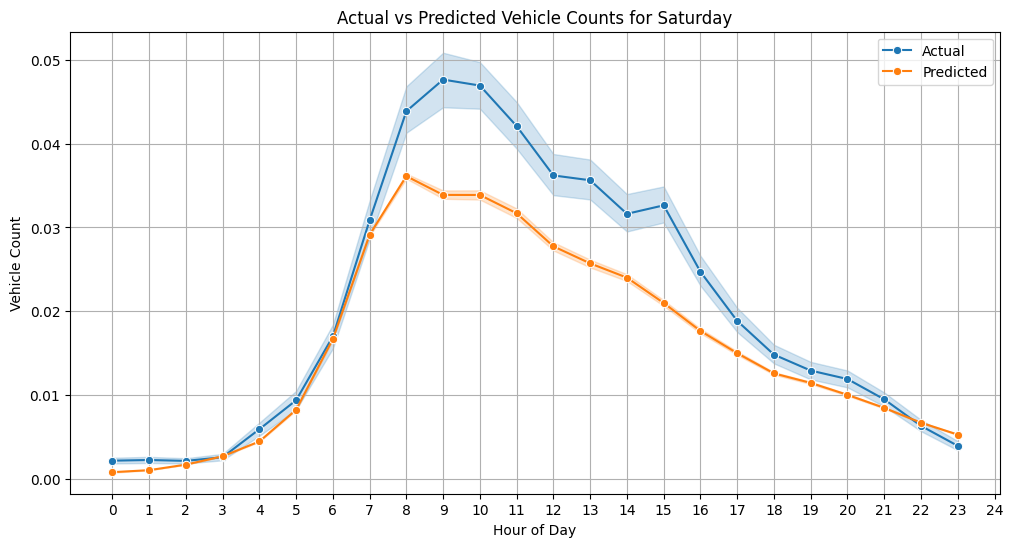

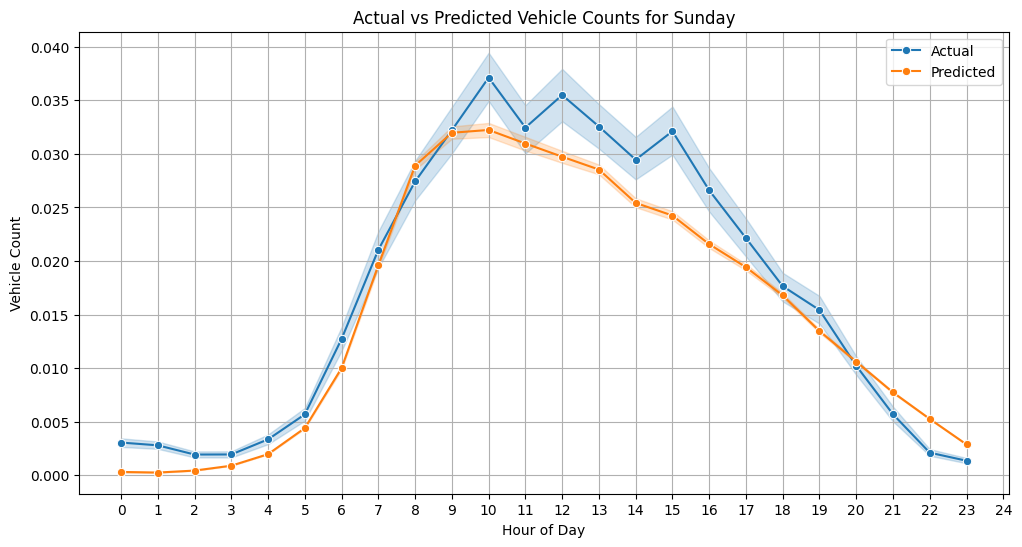

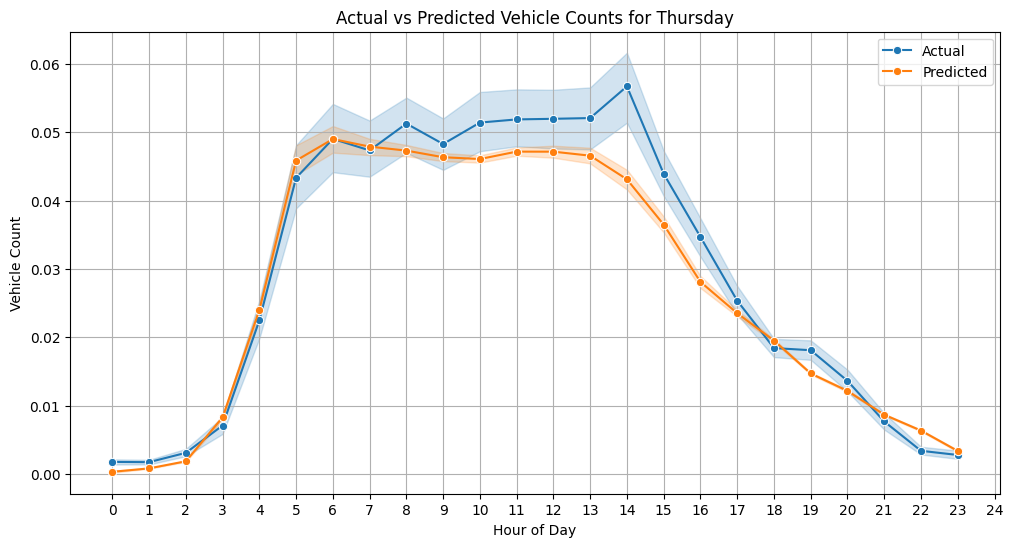

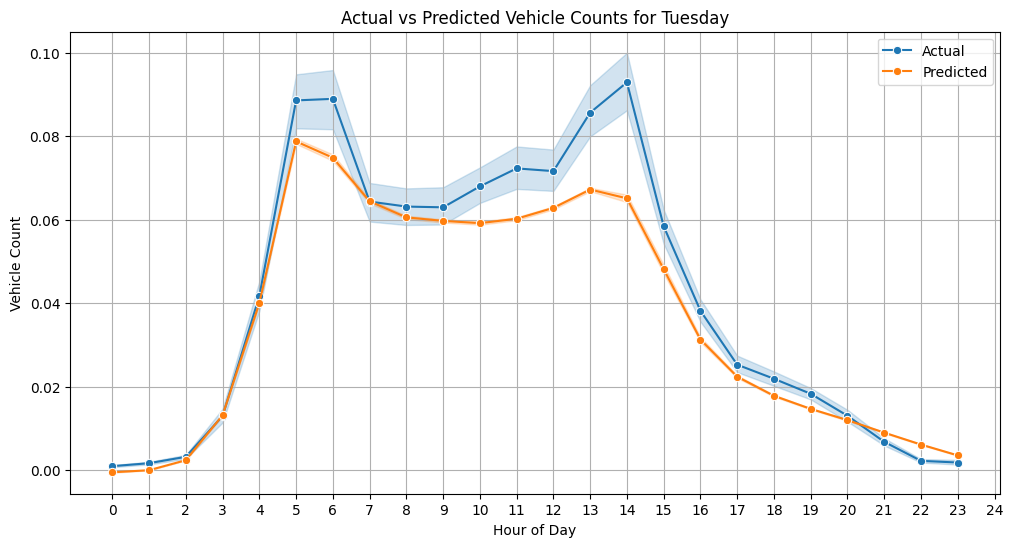

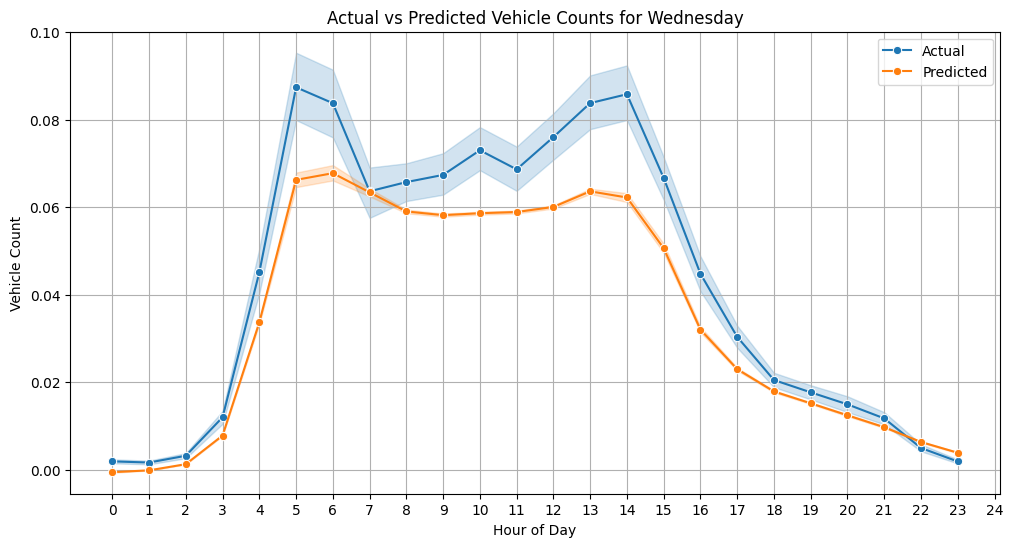

In [ ]:
# reverse transformation for 'Hour' in test_df for plotting purposes
test_df['Hour_denorm'] = scaler.inverse_transform(test_df[numerical_features])[:, numerical_features.index('Hour')]
plot_df = pd.DataFrame({
    'Day': test_df['Day'].iloc[sequence_length:],
    'Hour': test_df['Hour_denorm'].iloc[sequence_length:],
    'Actual': y_test.flatten(),
    'Predicted': y_pred_test.flatten()
})

for day in plot_df['Day'].cat.categories:
    day_df = plot_df[plot_df['Day'] == day]

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Hour', y='Actual', data=day_df, label='Actual', marker='o')
    sns.lineplot(x='Hour', y='Predicted', data=day_df, label='Predicted', marker='o')

    plt.title(f'Actual vs Predicted Vehicle Counts for {day}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Vehicle Count')
    plt.xticks(np.arange(0, 25, 1))  # modify last num for how many hours to show
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# denormalize pred vals
dummy_array = np.zeros((y_pred_test.shape[0], len(numerical_features)))
vehicle_count_index = numerical_features.index('vehicleCount')
dummy_array[:, vehicle_count_index] = y_pred_test.flatten()
denormalized_predictions = scaler.inverse_transform(dummy_array)[:, vehicle_count_index]

# denormalize actual values
dummy_array_actual = np.zeros((y_test.shape[0], len(numerical_features)))
dummy_array_actual[:, vehicle_count_index] = y_test.flatten()
denormalized_actual = scaler.inverse_transform(dummy_array_actual)[:, vehicle_count_index]

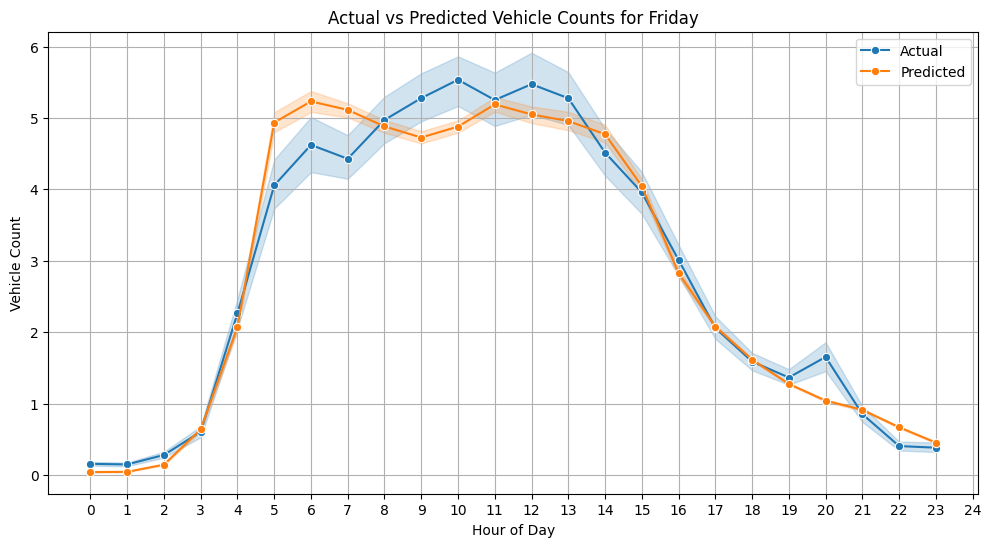

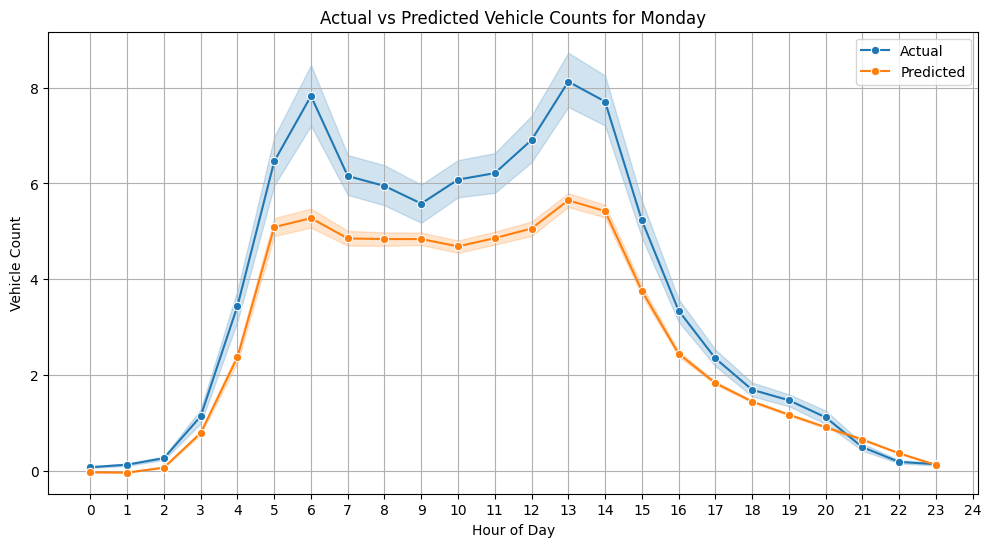

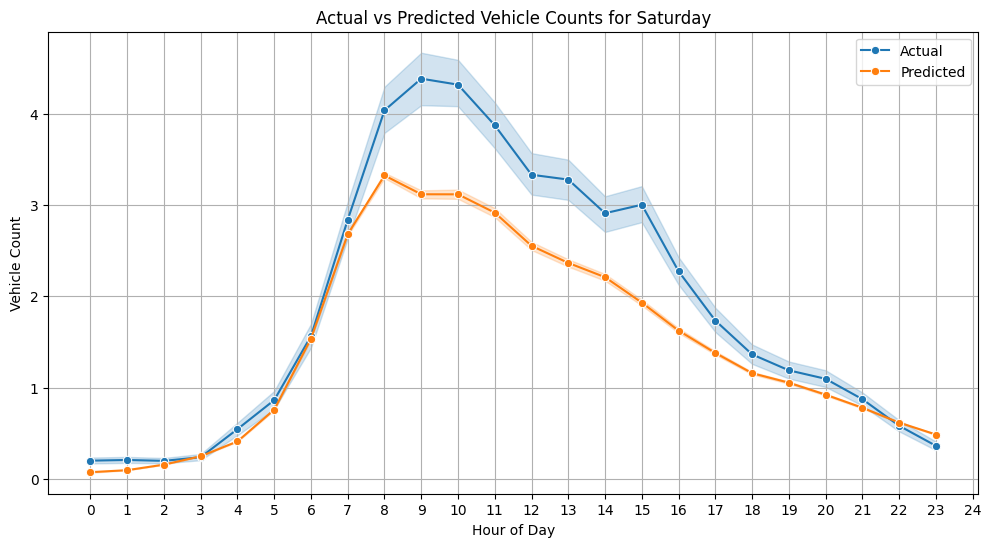

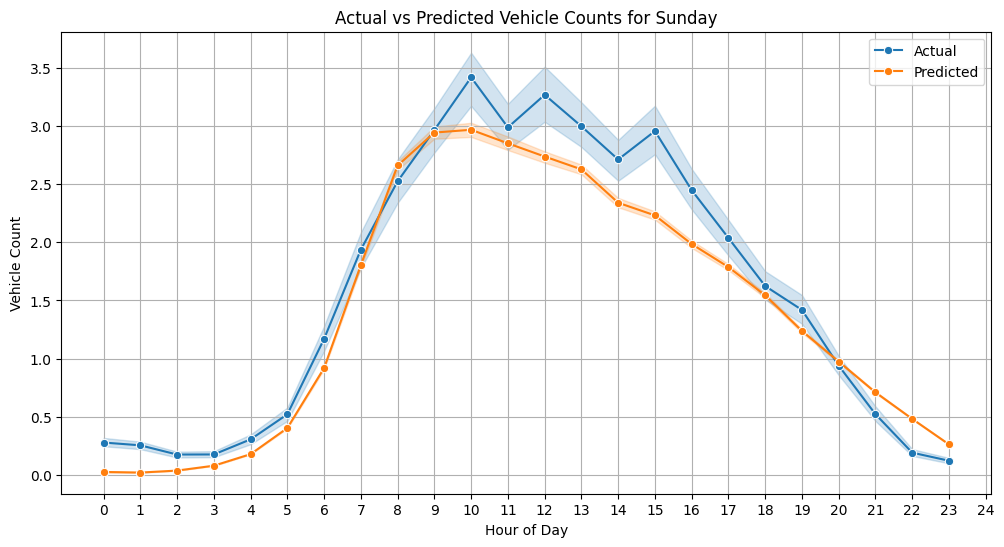

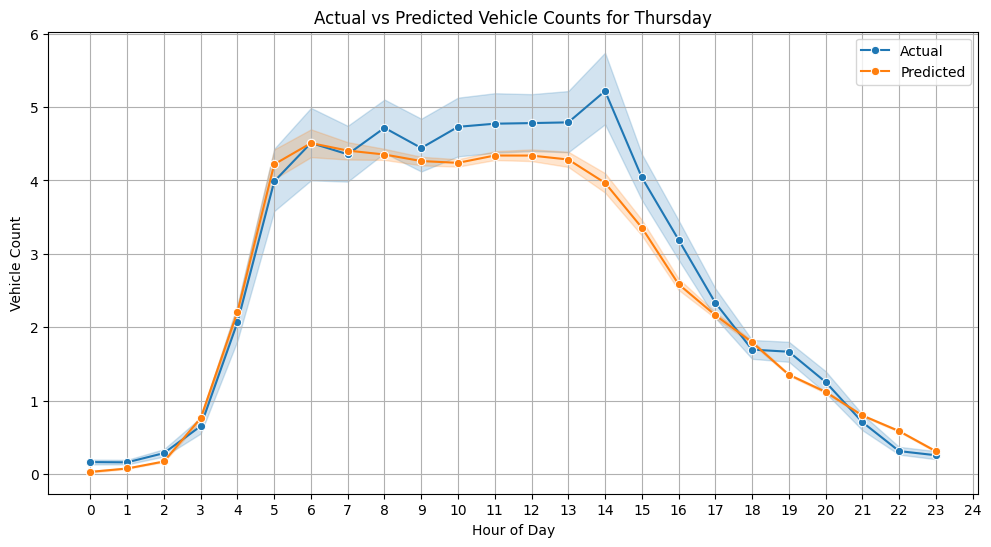

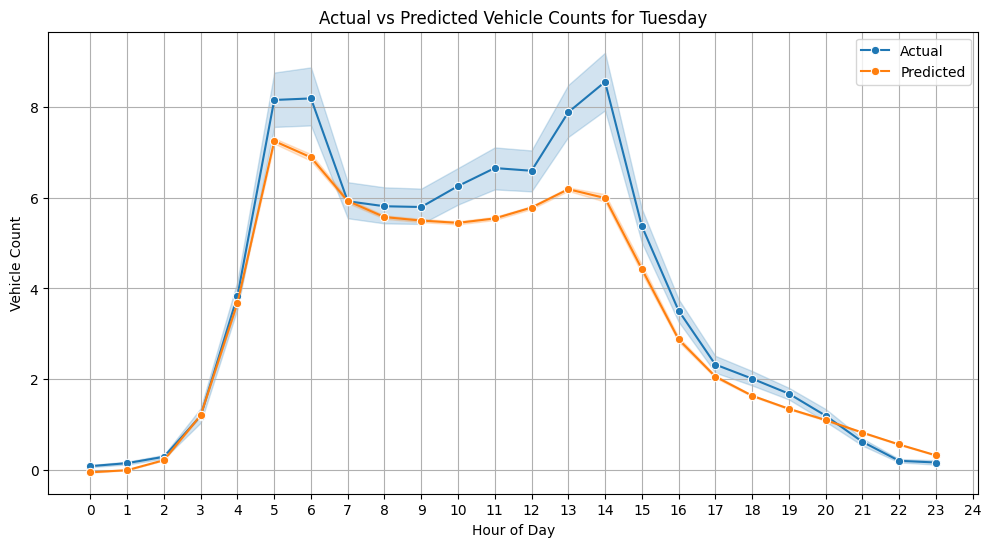

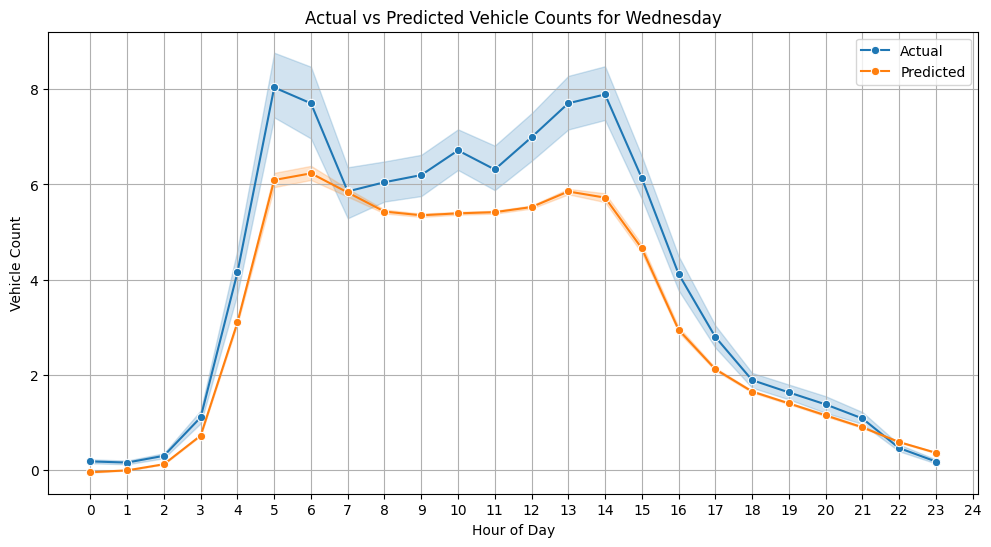

In [ ]:
plot_df = pd.DataFrame({
    'Day': test_df['Day'].iloc[sequence_length:],
    'Hour': test_df['Hour_denorm'].iloc[sequence_length:],
    'Actual': denormalized_actual,
    'Predicted': denormalized_predictions
})

for day in plot_df['Day'].cat.categories:
    day_df = plot_df[plot_df['Day'] == day]

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Hour', y='Actual', data=day_df, label='Actual', marker='o')
    sns.lineplot(x='Hour', y='Predicted', data=day_df, label='Predicted', marker='o')

    plt.title(f'Actual vs Predicted Vehicle Counts for {day}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Vehicle Count')
    plt.xticks(np.arange(0, 25, 1))
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# saving chart data to csv and excel file
results_df = pd.DataFrame({
    'Actual_vehicleCount': denormalized_actual,
    'Predicted_vehicleCount': denormalized_predictions
})

csv_file_path = '/content/drive/MyDrive/IoT_Project/predicted_vehicle_counts.csv'
results_df.to_csv(csv_file_path, index=False)

excel_file_path = '/content/drive/MyDrive/IoT_Project/predicted_vehicle_counts.xlsx'
results_df.to_excel(excel_file_path, index=False)